# Neural Combinatorial Optimization

In [1]:
#-*- coding: utf-8 -*-
import tensorflow as tf
distr = tf.contrib.distributions

import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from utils import embed_seq, encode_seq, full_glimpse, pointer
from data_generator import DataGenerator

## 1. Data Generator

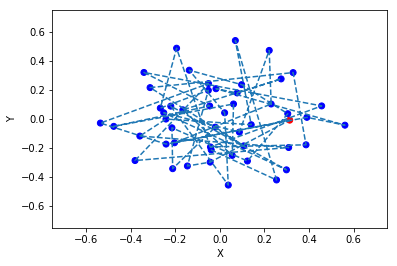

In [2]:
dataset = DataGenerator() # Create Data Generator

input_batch = dataset.test_batch(batch_size=128, max_length=50, dimension=2, seed=123) # Generate some data
dataset.visualize_2D_trip(input_batch[0]) # 2D plot for coord batch

## 2. Config

In [3]:
import argparse

parser = argparse.ArgumentParser(description='Configuration file')
arg_lists = []

def add_argument_group(name):
  arg = parser.add_argument_group(name)
  arg_lists.append(arg)
  return arg

def str2bool(v):
  return v.lower() in ('true', '1')

# Data
data_arg = add_argument_group('Data')
data_arg.add_argument('--batch_size', type=int, default=256, help='batch size')
data_arg.add_argument('--max_length', type=int, default=50, help='number of cities') ##### #####
data_arg.add_argument('--dimension', type=int, default=2, help='city dimension')

# Network
net_arg = add_argument_group('Network')
net_arg.add_argument('--input_embed', type=int, default=128, help='actor critic input embedding')
net_arg.add_argument('--num_neurons', type=int, default=512, help='encoder inner layer neurons')
net_arg.add_argument('--num_stacks', type=int, default=3, help='encoder num stacks')
net_arg.add_argument('--num_heads', type=int, default=16, help='encoder num heads')
net_arg.add_argument('--query_dim', type=int, default=360, help='decoder query space dimension')
net_arg.add_argument('--num_units', type=int, default=256, help='decoder and critic attention product space')
net_arg.add_argument('--num_neurons_critic', type=int, default=256, help='critic n-1 layer')

# Train / test parameters
train_arg = add_argument_group('Training')
train_arg.add_argument('--nb_steps', type=int, default=20000, help='nb steps')
train_arg.add_argument('--init_B', type=float, default=7., help='critic init baseline')
train_arg.add_argument('--lr_start', type=float, default=0.001, help='actor learning rate')
train_arg.add_argument('--lr_decay_step', type=int, default=5000, help='lr1 decay step')
train_arg.add_argument('--lr_decay_rate', type=float, default=0.96, help='lr1 decay rate')
train_arg.add_argument('--temperature', type=float, default=1.0, help='pointer initial temperature')
train_arg.add_argument('--C', type=float, default=10.0, help='pointer tanh clipping')
train_arg.add_argument('--is_training', type=str2bool, default=True, help='switch to inference mode when model is trained') 

def get_config():
  config, unparsed = parser.parse_known_args()
  return config, unparsed

In [4]:
config, _ = get_config()
dir_ = str(config.dimension)+'D_'+'TSP'+str(config.max_length) +'_b'+str(config.batch_size)+'_e'+str(config.input_embed)+'_n'+str(config.num_neurons)+'_s'+str(config.num_stacks)+'_h'+str(config.num_heads)+ '_q'+str(config.query_dim) +'_u'+str(config.num_units)+'_c'+str(config.num_neurons_critic)+ '_lr'+str(config.lr_start)+'_d'+str(config.lr_decay_step)+'_'+str(config.lr_decay_rate)+ '_T'+str(config.temperature)+ '_steps'+str(config.nb_steps)+'_i'+str(config.init_B) 
print(dir_)

2D_TSP50_b256_e128_n512_s3_h16_q360_u256_c256_lr0.001_d5000_0.96_T1.0_steps20000_i7.0


## 3. Model

In [5]:
class Actor(object):
    
    def __init__(self):
        
        # Data config
        self.batch_size = config.batch_size # batch size
        self.max_length = config.max_length # input sequence length (number of cities)
        self.dimension = config.dimension # dimension of a city (coordinates)
        
        # Network config
        self.input_embed = config.input_embed # dimension of embedding space
        self.num_neurons = config.num_neurons # dimension of hidden states (encoder)
        self.num_stacks = config.num_stacks # encoder num stacks
        self.num_heads = config.num_heads # encoder num heads
        self.query_dim = config.query_dim # decoder query space dimension
        self.num_units = config.num_units # dimension of attention product space (decoder and critic)
        self.num_neurons_critic = config.num_neurons_critic # critic n-1 layer num neurons
        self.initializer = tf.contrib.layers.xavier_initializer() # variables initializer
        
        # Training config (actor and critic)
        self.global_step = tf.Variable(0, trainable=False, name="global_step") # actor global step
        self.global_step2 = tf.Variable(0, trainable=False, name="global_step2") # critic global step
        self.init_B = config.init_B # critic initial baseline
        self.lr_start = config.lr_start # initial learning rate
        self.lr_decay_step = config.lr_decay_step # learning rate decay step
        self.lr_decay_rate = config.lr_decay_rate # learning rate decay rate
        self.is_training = config.is_training # swith to False if test mode

        # Tensor block holding the input sequences [Batch Size, Sequence Length, Features]
        self.input_ = tf.placeholder(tf.float32, [None, self.max_length, self.dimension], name="input_coordinates")
        
        with tf.variable_scope("actor"): self.encode_decode()
        with tf.variable_scope("critic"): self.build_critic()
        with tf.variable_scope("environment"): self.build_reward()
        with tf.variable_scope("optimizer"): self.build_optim()
        self.merged = tf.summary.merge_all()    
        
        
    def encode_decode(self):
        actor_embedding = embed_seq(input_seq=self.input_, from_=self.dimension, to_= self.input_embed, is_training=self.is_training, BN=True, initializer=self.initializer)
        actor_encoding = encode_seq(input_seq=actor_embedding, input_dim=self.input_embed, num_stacks=self.num_stacks, num_heads=self.num_heads, num_neurons=self.num_neurons, is_training=self.is_training)
        if self.is_training == False:
            actor_encoding = tf.tile(actor_encoding,[self.batch_size,1,1])
        
        idx_list, log_probs, entropies = [], [], [] # tours index, log_probs, entropies
        mask = tf.zeros((self.batch_size, self.max_length)) # mask for actions
        
        n_hidden = actor_encoding.get_shape().as_list()[2] # input_embed
        W_ref = tf.get_variable("W_ref",[1, n_hidden, self.num_units],initializer=self.initializer)
        W_q = tf.get_variable("W_q",[self.query_dim, self.num_units],initializer=self.initializer)
        v = tf.get_variable("v",[self.num_units],initializer=self.initializer)
        
        encoded_ref = tf.nn.conv1d(actor_encoding, W_ref, 1, "VALID") # actor_encoding is the ref for actions [Batch size, seq_length, n_hidden]
        query1 = tf.zeros((self.batch_size, n_hidden)) # initial state
        query2 = tf.zeros((self.batch_size, n_hidden)) # previous state
        query3 = tf.zeros((self.batch_size, n_hidden)) # previous previous state
            
        W_1 =tf.get_variable("W_1",[n_hidden, self.query_dim],initializer=self.initializer) # update trajectory (state)
        W_2 =tf.get_variable("W_2",[n_hidden, self.query_dim],initializer=self.initializer)
        W_3 =tf.get_variable("W_3",[n_hidden, self.query_dim],initializer=self.initializer)
    
        for step in range(self.max_length): # sample from POINTER      
            query = tf.nn.relu(tf.matmul(query1, W_1) + tf.matmul(query2, W_2) + tf.matmul(query3, W_3))
            logits = pointer(encoded_ref=encoded_ref, query=query, mask=mask, W_ref=W_ref, W_q=W_q, v=v, C=config.C, temperature=config.temperature)
            prob = distr.Categorical(logits) # logits = masked_scores
            idx = prob.sample()
            
            idx_list.append(idx) # tour index
            log_probs.append(prob.log_prob(idx)) # log prob
            entropies.append(prob.entropy()) # entropies
            mask = mask + tf.one_hot(idx, self.max_length) # mask
            
            idx_ = tf.stack([tf.range(self.batch_size,dtype=tf.int32), idx],1) # idx with batch   
            query3 = query2
            query2 = query1
            query1 = tf.gather_nd(actor_encoding, idx_) # update trajectory (state)
            
        idx_list.append(idx_list[0]) # return to start
        self.tour = tf.stack(idx_list, axis=1) # permutations
        self.log_prob = tf.add_n(log_probs) # corresponding log-probability for backprop
        self.entropies = tf.add_n(entropies)
        tf.summary.scalar('log_prob_mean', tf.reduce_mean(self.log_prob))
        tf.summary.scalar('entropies_mean', tf.reduce_mean(self.entropies))
        
        
    def build_reward(self): # reorder input % tour and return tour length (euclidean distance)
        self.permutations = tf.stack([tf.tile(tf.expand_dims(tf.range(self.batch_size,dtype=tf.int32),1),[1,self.max_length+1]),self.tour],2)
        if self.is_training==True:
            self.ordered_input_ = tf.gather_nd(self.input_,self.permutations)
        else:
            self.ordered_input_ = tf.gather_nd(tf.tile(self.input_,[self.batch_size,1,1]),self.permutations)
        self.ordered_input_ = tf.transpose(self.ordered_input_,[2,1,0]) # [features, seq length +1, batch_size]   Rq: +1 because end = start    
        
        ordered_x_ = self.ordered_input_[0] # ordered x, y coordinates [seq length +1, batch_size]
        ordered_y_ = self.ordered_input_[1] # ordered y coordinates [seq length +1, batch_size]          
        delta_x2 = tf.transpose(tf.square(ordered_x_[1:]-ordered_x_[:-1]),[1,0]) # [batch_size, seq length]        delta_x**2
        delta_y2 = tf.transpose(tf.square(ordered_y_[1:]-ordered_y_[:-1]),[1,0]) # [batch_size, seq length]        delta_y**2

        inter_city_distances = tf.sqrt(delta_x2+delta_y2) # sqrt(delta_x**2 + delta_y**2) this is the euclidean distance between each city: depot --> ... ---> depot      [batch_size, seq length]
        self.distances = tf.reduce_sum(inter_city_distances, axis=1) # [batch_size]
        self.reward = tf.cast(self.distances,tf.float32) # define reward from tour length  
        tf.summary.scalar('reward_mean', tf.reduce_mean(self.reward))

            
    def build_critic(self):
        critic_embedding = embed_seq(input_seq=self.input_, from_=self.dimension, to_= self.input_embed, is_training=self.is_training, BN=True, initializer=self.initializer)
        critic_encoding = encode_seq(input_seq=critic_embedding, input_dim=self.input_embed, num_stacks=self.num_stacks, num_heads=self.num_heads, num_neurons=self.num_neurons, is_training=self.is_training)
        frame = full_glimpse(ref=critic_encoding, from_=self.input_embed, to_=self.num_units, initializer=tf.contrib.layers.xavier_initializer()) # Glimpse on critic_encoding [Batch_size, input_embed]
        
        with tf.variable_scope("ffn"): #  2 dense layers for predictions
            h0 = tf.layers.dense(frame, self.num_neurons_critic, activation=tf.nn.relu, kernel_initializer=self.initializer)
            w1 = tf.get_variable("w1", [self.num_neurons_critic, 1], initializer=self.initializer)
            b1 = tf.Variable(self.init_B, name="b1")
            self.predictions = tf.squeeze(tf.matmul(h0, w1)+b1)
            tf.summary.scalar('predictions_mean', tf.reduce_mean(self.predictions))
            
    def build_optim(self):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops): # Update moving_mean and moving_variance for BN
            
            with tf.name_scope('reinforce'):
                lr1 = tf.train.natural_exp_decay(learning_rate=self.lr_start, global_step=self.global_step, decay_steps=self.lr_decay_step, decay_rate=self.lr_decay_rate, staircase=False, name="learning_rate1") # learning rate actor
                tf.summary.scalar('lr', lr1)
                opt1 = tf.train.AdamOptimizer(learning_rate=lr1) # Optimizer
                self.loss = tf.reduce_mean(tf.stop_gradient(self.reward-self.predictions)*self.log_prob, axis=0) # loss actor
                gvs1 = opt1.compute_gradients(self.loss) # gradients
                capped_gvs1 = [(tf.clip_by_norm(grad, 1.), var) for grad, var in gvs1 if grad is not None] # L2 clip
                self.trn_op1 = opt1.apply_gradients(grads_and_vars=capped_gvs1, global_step=self.global_step) # minimize op actor
                
            with tf.name_scope('state_value'):
                lr2 = tf.train.natural_exp_decay(learning_rate=self.lr_start, global_step=self.global_step2, decay_steps=self.lr_decay_step, decay_rate=self.lr_decay_rate, staircase=False, name="learning_rate2") # learning rate critic
                opt2 = tf.train.AdamOptimizer(learning_rate=lr2) # Optimizer
                loss2 = tf.losses.mean_squared_error(self.reward, self.predictions) # loss critic
                gvs2 = opt2.compute_gradients(loss2) # gradients
                capped_gvs2 = [(tf.clip_by_norm(grad, 1.), var) for grad, var in gvs2 if grad is not None] # L2 clip
                self.trn_op2 = opt2.apply_gradients(grads_and_vars=capped_gvs2, global_step=self.global_step2) # minimize op critic

In [6]:
tf.reset_default_graph()
actor = Actor() # Build graph

In [7]:
variables_to_save = [v for v in tf.global_variables() if 'Adam' not in v.name] # Save & restore all the variables.
saver = tf.train.Saver(var_list=variables_to_save, keep_checkpoint_every_n_hours=1.0)   

In [8]:
with tf.Session() as sess: # start session
    sess.run(tf.global_variables_initializer()) # Run initialize op
    variables_names = [v.name for v in tf.trainable_variables() if 'Adam' not in v.name]
    values = sess.run(variables_names)
    for k, v in zip(variables_names, values):
        #print("Variable: ", k, "Shape: ", v.shape) # print all variables
        pass

## 4. Train

In [ ]:
np.random.seed(123) # reproducibility
tf.set_random_seed(123)

In [ ]:
with tf.Session() as sess: # start session
    sess.run(tf.global_variables_initializer()) # run initialize op
    writer = tf.summary.FileWriter('summary/'+dir_, sess.graph) # summary writer
    
    for i in tqdm(range(config.nb_steps)): # Forward pass & train step
        input_batch = dataset.train_batch(actor.batch_size, actor.max_length, actor.dimension)
        feed = {actor.input_: input_batch} # get feed dict
        reward, predictions, summary, _, _ = sess.run([actor.reward, actor.predictions, actor.merged, actor.trn_op1, actor.trn_op2], feed_dict=feed)

        if i % 50 == 0: 
            print('reward',np.mean(reward))
            print('predictions',np.mean(predictions))
            writer.add_summary(summary,i)
        
    save_path = "save/"+dir_
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    saver.save(sess, save_path+"/actor.ckpt") # save the variables to disk
    print("Training COMPLETED! Model saved in file: %s" % save_path)

##  5. Test

In [9]:
config.is_training = False
config.batch_size = 10 ##### #####
config.max_length = 50 ##### #####
config.temperature = 1.2 ##### #####

tf.reset_default_graph()
actor = Actor() # Build graph

In [10]:
variables_to_save = [v for v in tf.global_variables() if 'Adam' not in v.name] # Save & restore all the variables.
saver = tf.train.Saver(var_list=variables_to_save, keep_checkpoint_every_n_hours=1.0)   

INFO:tensorflow:Restoring parameters from save/2D_TSP50_b256_e128_n512_s3_h16_q360_u256_c256_lr0.001_d5000_0.96_T1.0_steps20000_i7.0/actor.ckpt


  0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

reward (before 2 opt) 5.97343
reward (with 2 opt) 5.82403824394


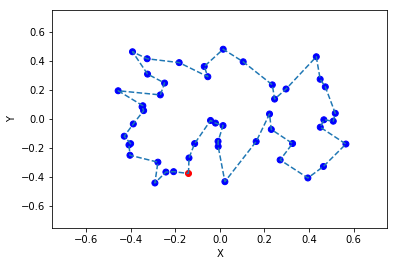

 10%|██████████▋                                                                                                | 1/10 [00:00<00:08,  1.06it/s]

reward (before 2 opt) 5.61107
reward (with 2 opt) 5.53872509528


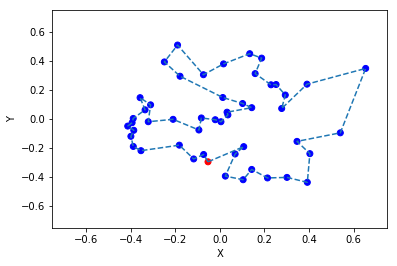

 20%|█████████████████████▍                                                                                     | 2/10 [00:01<00:06,  1.25it/s]

reward (before 2 opt) 5.69439
reward (with 2 opt) 5.68212340534


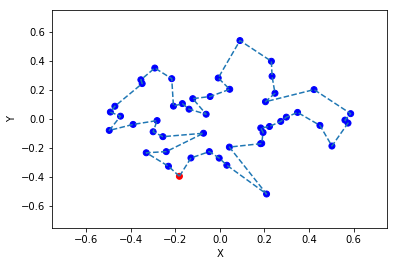

 30%|████████████████████████████████                                                                           | 3/10 [00:02<00:05,  1.34it/s]

reward (before 2 opt) 6.29229
reward (with 2 opt) 6.19786760043


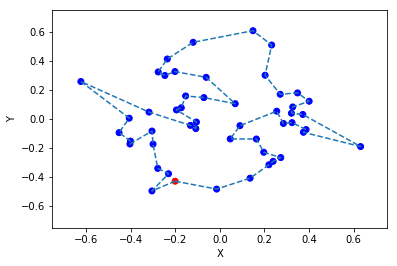

 40%|██████████████████████████████████████████▊                                                                | 4/10 [00:02<00:04,  1.38it/s]

reward (before 2 opt) 6.15702
reward (with 2 opt) 5.95170531271


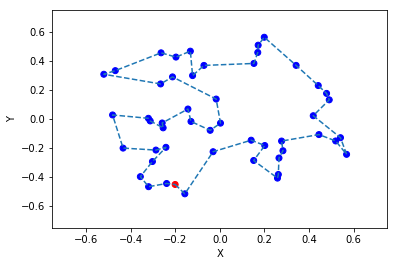

 50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:03<00:03,  1.40it/s]

reward (before 2 opt) 6.12941
reward (with 2 opt) 5.95897214142


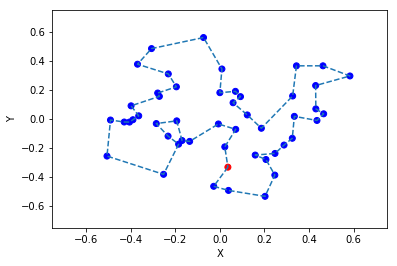

 60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:04<00:02,  1.40it/s]

reward (before 2 opt) 5.74201
reward (with 2 opt) 5.70336987843


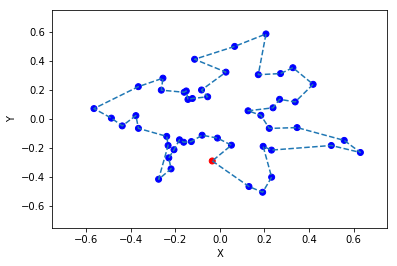

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:05<00:02,  1.38it/s]

reward (before 2 opt) 6.25299
reward (with 2 opt) 6.24826043012


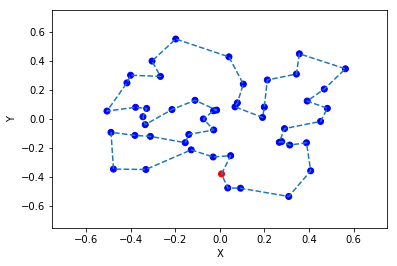

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:05<00:01,  1.41it/s]

reward (before 2 opt) 5.60115
reward (with 2 opt) 5.57113499111


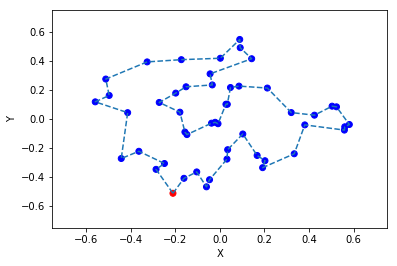

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:06<00:00,  1.43it/s]

reward (before 2 opt) 6.01194
reward (with 2 opt) 5.97015351572


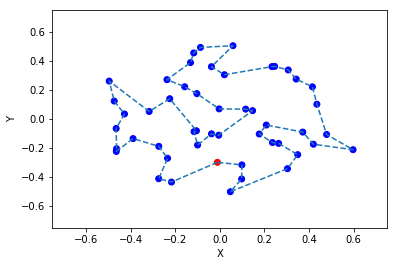

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]


Testing COMPLETED ! Mean length1: 5.94657 Mean length2: 5.86463506145


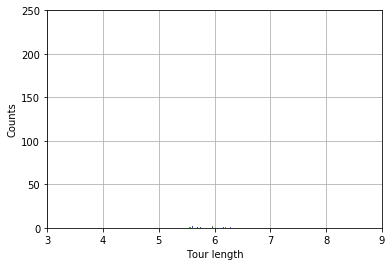

In [11]:
with tf.Session() as sess:  # start session
    sess.run(tf.global_variables_initializer()) # Run initialize op
    
    save_path = "save/"+dir_
    saver.restore(sess, save_path+"/actor.ckpt") # Restore variables from disk.
    
    predictions_length, predictions_length_w2opt = [], []
    for i in tqdm(range(1000)): # test instance
        seed_ = 1+i
        input_batch = dataset.test_batch(1, actor.max_length, actor.dimension, seed=seed_, shuffle=False)
        feed = {actor.input_: input_batch} # Get feed dict
        tour, reward = sess.run([actor.tour, actor.reward], feed_dict=feed) # sample tours

        j = np.argmin(reward) # find best solution
        best_permutation = tour[j][:-1]
        predictions_length.append(reward[j])
        print('reward (before 2 opt)',reward[j])
        #dataset.visualize_2D_trip(input_batch[0][best_permutation])
        #dataset.visualize_sampling(tour)
        
        opt_tour, opt_length = dataset.loop2opt(input_batch[0][best_permutation])
        predictions_length_w2opt.append(opt_length)
        print('reward (with 2 opt)', opt_length)
        dataset.visualize_2D_trip(opt_tour)
        
    predictions_length = np.asarray(predictions_length) # average tour length
    predictions_length_w2opt = np.asarray(predictions_length_w2opt)
    print("Testing COMPLETED ! Mean length1:",np.mean(predictions_length), "Mean length2:",np.mean(predictions_length_w2opt))

    n1, bins1, patches1 = plt.hist(predictions_length, 50, facecolor='b', alpha=0.75) # Histogram
    n2, bins2, patches2 = plt.hist(predictions_length_w2opt, 50, facecolor='g', alpha=0.75) # Histogram
    plt.xlabel('Tour length')
    plt.ylabel('Counts')
    plt.axis([3., 9., 0, 250])
    plt.grid(True)
    plt.show()